In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Attention to feedback updating function
def smooth(x,omega,lambda_par):
    return lambda_par*x + (1-lambda_par)*omega

# Logistic function for state transition
def probTrans(Attention_To_Feed,theta):
    return 1/(1 + np.exp(theta*(1/2 - Attention_To_Feed)))

# Likelihood over the rules
def Likelihood(matching_vector,y,state):
    l = np.array([matching_vector==y, 1 - (matching_vector==y)])
    ll = l[state]/sum(l[state])
    return np.array([1/3,1/3,1/3])*0.0001 + ll*0.9999

# Posterior over the rules
def Posterior(prior,likelihood):
    n = prior * likelihood
    d = sum(n)
    return n/d
    
# Corrupted Posterior over the rules
def systemPosterior(pi_par,posterior):
    g = np.array([1/3,1/3,1/3])
    f = posterior
    h_ = pi_par*g + (1-pi_par)*f
    h = h_ / sum(h_)
    return h

# Generate the sequence of target cards codified as features matching vectors in M (0: no ambiguity, 1: ambiguity)
def MatchingMatrix(n_trials,ambiguity):
    M = [np.random.choice([1,2,3,4],3,replace=ambiguity) for _ in range(n_trials)]
    return M 

In [40]:
def GenerativeModel(Parameters,M):

    # Parameters Setting #
    lambda_par = Parameters[0]
    alpha_par = Parameters[1]
    beta_par = Parameters[2]
    pi_par = Parameters[3]
    
    # Initialize Vectors #
    max_trials = len(M) # Set the maximum number of possible trials (128 trials for the Heaton's version of the WCST)
    target_rule = np.zeros(max_trials, dtype=int) # Initialize the vector of correct rules
    correct_stimulus_card = np.zeros(max_trials, dtype=int) # Initialize the vector of correct stimulus cards
    S = np.zeros(max_trials, dtype=int) # Initialize the vector of the states (0: set-maintainance, 1: set-shifting)
    h = np.zeros((max_trials,3)) # Initialize the vectors of the system's likelihood probabilities
    rule_choice = np.zeros(max_trials, dtype=int) # Initialize the vector of the agent's rules choice
    Y = np.zeros(max_trials, dtype=int) # Initialize the vector of the agent's stimulus cards choice
    X = np.zeros(max_trials, dtype=int) # Initialize the vector of received feedback (1: correct, 0: error)
    omega = np.zeros(max_trials) # Initialize the vector of the attention to reward process
    delta = np.zeros(max_trials) # Initialize the vector of the attention to punishment process
    gamma_00 = np.zeros(max_trials) # Initialize the vector of self-transition probabilities for state 0 (set-maintenance)
    gamma_11 = np.zeros(max_trials) # Initialize the vector of self-transition probabilities for state 1 (set-shifting)
    target_rules_vector = np.tile(np.array([1,2,3]),10) # Vector of possible target rules
    
    # First Trial (the first correct response is given as in the standard version of Heaton's WCST) #
    i = 0 # Target rule indicator
    target_rule[0] = target_rules_vector[i] # Actual target rule
    correct_stimulus_card[0] = M[0][target_rule[0]-1] # Correct stimulus card
    S[0] = 0 # Start at state 0 (set-maintenance)
    h[0] = np.array([1/3,1/3,1/3]) # Prior over the rules
    rule_choice[0] = 1 # Sample the first correct rule
    Y[0] = M[0][rule_choice[0]-1] # Select the first correct stimulus card
    X[0] = 1 # Correct response
    omega[0] = smooth(X[0],0.5,lambda_par) # Update omega
    gamma_00[0] = probTrans(omega[0],alpha_par) # Compute transition probabilities
    gamma_01 = 1 - gamma_00[0]
    gamma_11[0] = probTrans(omega[0],beta_par) # Compute transition probabilities
    gamma_10 = 1 - gamma_11[0]
    G = np.array([[gamma_00[0],gamma_01],[gamma_10,gamma_11[0]]]) # State Transition Matrix
    
    # Task execution #
    T = len(M) # Set the maximum number of trials attainable
    c = 0 # Initialize the stopping criterion
    for t in range(1,T):
        target_rule[t] = target_rules_vector[i] # Current target rule
        correct_stimulus_card[t] = M[t][target_rule[t]-1] # Current correct stimulus card
        S[t] = np.random.choice([0,1],1,p=G[S[t-1]]) # Sampling the current state
        f = Likelihood(M[t-1],Y[t-1],S[t]) # Compute the likelihood over the rules condition on the current state
        hh = Posterior(h[t-1],f) # Compute the Posterior over the rules
        h[t] = systemPosterior(pi_par,hh) # Compute the corrupted Posterior over the rules
        rule_choice[t] = np.random.choice([1,2,3],1,p=h[t]) # Sampling the rule 
        Y[t] = M[t][rule_choice[t]-1] # Select the stimulus card according to the rule
        X[t] = int(Y[t] == correct_stimulus_card[t]) # Feedback
        omega[t] = smooth(X[t],omega[t-1],lambda_par) # Update omega for the next state transition
        gamma_00[t] = probTrans(omega[t],alpha_par) # Compute the transition probabilities for the next trial
        gamma_01 = 1 - gamma_00[t]
        gamma_11[t] = probTrans(omega[t],beta_par) # Compute the transition probabilities for the next trial
        gamma_10 = 1 - gamma_11[t]
        G = np.array([[gamma_00[t],gamma_01],[gamma_10,gamma_11[t]]]) # Transition Matrix for the next trial
        
        # Stopping condition (The task ends when the agent collects a series of 6 10 consecutive correct responses)
        if X[t] == 1:
            if X[t] == X[t-1]:
                c = c + 1
            else:
                c = 0
        if c == 9:
            i = i + 1
            c = 0
            
        if i == 6:
            break
    
    # Set the output dataframe for the generated data
    out_dat = {'S': S[0:t+1], 
               'target_rule': target_rule[0:t+1], 
               'rule_choice': rule_choice[0:t+1], 
               'correct_Y': correct_stimulus_card[0:t+1],
               'Y': Y[0:t+1],
               'X': X[0:t+1],
               'omega': omega[0:t+1],
               'delta': delta[0:t+1],
               'g00': gamma_00[0:t+1],
               'g11': gamma_11[0:t+1]}
    
    # Set the output dataframe for the system's likelihood over the rules
    out_prob = {'color': np.round(h[0:t+1,0],3), 'shape': np.round(h[0:t+1,1]), 'number': np.round(h[0:t+1,2])}
    
    # output
    OUT = [pd.DataFrame(data = out_dat), pd.DataFrame(data = out_prob)]
    
    return OUT

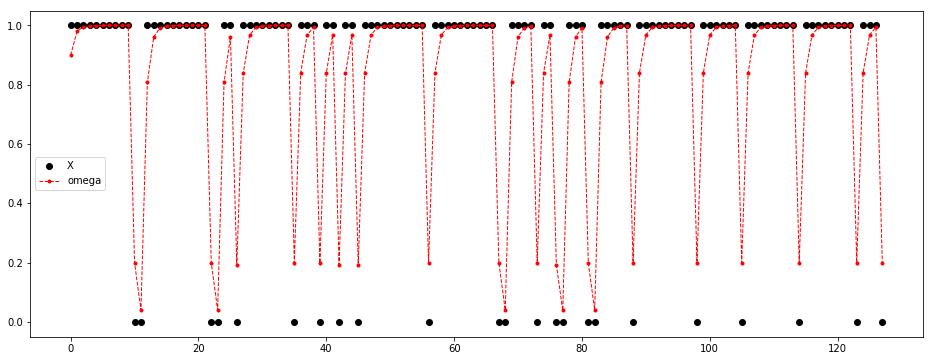

In [53]:
# Simulation #
M = MatchingMatrix(128,0) # Generate a Features Matching Matrix to simulate 128 WCST trials
Parameters = [0.8, 10, -10, 0.01] # lambda, alpha, beta, pi
data = GenerativeModel(Parameters,M) # Generate data

# Plot #
plt.figure(figsize=(16,6))
plt.plot(data[0].X,'ko')
plt.plot(data[0].omega,'ro--', linewidth=1, markersize=3)
plt.legend(loc='center left')
plt.show()